In [1]:
import os
import requests
import json
import re
from dotenv import load_dotenv
load_dotenv()
api=os.getenv("WEATHER_API")

base_url='http://api.weatherapi.com/v1/current.json'
city='Nagpur'

url=f'{base_url}?key={api}&q={city}'

res=requests.get(url).json()


python-dotenv could not parse statement starting at line 12


In [2]:
res

{'location': {'name': 'Nagpur',
  'region': 'Maharashtra',
  'country': 'India',
  'lat': 21.15,
  'lon': 79.1,
  'tz_id': 'Asia/Kolkata',
  'localtime_epoch': 1761216813,
  'localtime': '2025-10-23 16:23'},
 'current': {'last_updated_epoch': 1761216300,
  'last_updated': '2025-10-23 16:15',
  'temp_c': 31.4,
  'temp_f': 88.5,
  'is_day': 1,
  'condition': {'text': 'Mist',
   'icon': '//cdn.weatherapi.com/weather/64x64/day/143.png',
   'code': 1030},
  'wind_mph': 6.7,
  'wind_kph': 10.8,
  'wind_degree': 66,
  'wind_dir': 'ENE',
  'pressure_mb': 1009.0,
  'pressure_in': 29.8,
  'precip_mm': 0.0,
  'precip_in': 0.0,
  'humidity': 55,
  'cloud': 25,
  'feelslike_c': 36.5,
  'feelslike_f': 97.8,
  'windchill_c': 29.3,
  'windchill_f': 84.7,
  'heatindex_c': 32.1,
  'heatindex_f': 89.8,
  'dewpoint_c': 21.4,
  'dewpoint_f': 70.5,
  'vis_km': 5.0,
  'vis_miles': 3.0,
  'uv': 0.8,
  'gust_mph': 9.4,
  'gust_kph': 15.1,
  'short_rad': 637.14,
  'diff_rad': 94.66,
  'dni': 644.91,
  'gti': 47

In [3]:
print(json.dumps(res, indent=4))

{
    "location": {
        "name": "Nagpur",
        "region": "Maharashtra",
        "country": "India",
        "lat": 21.15,
        "lon": 79.1,
        "tz_id": "Asia/Kolkata",
        "localtime_epoch": 1761216813,
        "localtime": "2025-10-23 16:23"
    },
    "current": {
        "last_updated_epoch": 1761216300,
        "last_updated": "2025-10-23 16:15",
        "temp_c": 31.4,
        "temp_f": 88.5,
        "is_day": 1,
        "condition": {
            "text": "Mist",
            "icon": "//cdn.weatherapi.com/weather/64x64/day/143.png",
            "code": 1030
        },
        "wind_mph": 6.7,
        "wind_kph": 10.8,
        "wind_degree": 66,
        "wind_dir": "ENE",
        "pressure_mb": 1009.0,
        "pressure_in": 29.8,
        "precip_mm": 0.0,
        "precip_in": 0.0,
        "humidity": 55,
        "cloud": 25,
        "feelslike_c": 36.5,
        "feelslike_f": 97.8,
        "windchill_c": 29.3,
        "windchill_f": 84.7,
        "heatindex_c": 3

### LangGraph 

In [4]:
import os
import requests
import json
import re
from langchain_groq import ChatGroq
from langgraph.graph import START,StateGraph,END
from typing import List,TypedDict,Dict,Union,Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage
import datetime
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from datetime import datetime

# Intilizing LLM

In [4]:
groq=os.getenv('GROQ_API_KEY')
llm=ChatGroq(api_key=groq,model='meta-llama/llama-4-maverick-17b-128e-instruct')

## STATE SCHEMA

In [5]:
class Weather(TypedDict):
    city:str
    weather_data:Dict
    disaster_type:str
    severity:str
    response:str
    messages:List[Union[SystemMessage,AIMessage,HumanMessage]]
    alerts:List[str]
    human_approved:bool

# Get Data

In [17]:
def get_weather_data(state:Weather):

    api=os.getenv("WEATHER_API")
    base_url='http://api.weatherapi.com/v1/current.json'

    city=state['city']

    url = f'{base_url}?key={api}&q={city}'

    try:



        response=requests.get(url)
        response.raise_for_status()

        data=response.json()

        current=data.get('current',{})
        condition=current.get('condition',{})

        weather_data={
            'weather':condition.get('text','N\A'),
            'wind_kph':current.get('wind_kph','N\A'),
            'wind_degree':current.get('wind_degree','N\A'),
            'temp_c':current.get('temp_c','N\A'),
            'cloud':current.get('cloud','N\A'),
            'pressure_mb':current.get('pressure_mb','N\A'),
            'humidity':current.get('humidity','N\A'),
            'heatindex_c':current.get('heatindex_c','N\A'),
            'precipitate_mm':current.get('precip_mm','N\A')
        }


        return{
            **state,
            'weather_data':weather_data,
            'messages':state['messages']+[SystemMessage(content=f'Weather data successfylly fetched for {state["city"]}')]
        }

    except Exception as e:
        error_data = {
            "weather": "N/A",
            "wind_kph": "N/A",
            "wind_deg": "N/A",
            "cloud": "N/A",
            'heat_index_c':'N/A',
            "temp_c": "N/A",
            "humidity": "N/A",
            "pressure_mb": "N/A",
            'precipitate_mm':"N/A"

        }
        return {
            **state,
            "weather_data": error_data,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to fetch weather data for {state['city']}: {str(e)}")]
        }




# Disaster type and Severity measure

In [19]:


def disaster_type(state: Weather):
    weather_data = state["weather_data"]

    
    prompt = ChatPromptTemplate.from_template(
        "Analyze the following weather data and determine:\n"
        "1. The potential disaster type ( Hurricane, Flood, Heatwave, Severe Storm, Winter Storm).If you find nothing return (No Immediate Threat)\n"
        "2. The severity level (choose one:  high, medium, low)\n\n"
        "Weather data:\n{weather_data}\n\n"
        "Respond strictly in JSON format as:\n"
        "{{\"disaster_type\": \"...\", \"severity\": \"...\"}}"
    )

    try:
        chain = prompt | llm
        response = chain.invoke( {"weather_data":weather_data}).content
        disaster_type = "Unknown"
        severity="Unknown"

        match = re.search(r'"disaster_type"\s*:\s*"([^"]+)"', response)
        if match:
            disaster_type = match.group(1)

        match = re.search(r'"severity"\s*:\s*"([^"]+)"', response)
        if match:
            severity = match.group(1)


        return {
            **state,
            "disaster_type": disaster_type,
            "severity": severity,
            
            "messages": state["messages"] + [
                SystemMessage(content=f"🌦 Disaster type: **{disaster_type}**, Severity: **{severity}**")
            ]
        }

    except Exception as e:
        return {
            **state,
            "disaster_type": "Analysis Failed",
            "messages": state['messages'] + [
                SystemMessage(content=f"⚠️ Failed to analyze disaster type: {str(e)}")
            ]
        }


# Emergency Responce plan

In [6]:
def emergency_response(state:Weather):
    weather_data=state['weather_data']
    disaster_type=state['disaster_type']
    severity=state['severity']

    prompt=ChatPromptTemplate.from_template(
        'Analyze the weather conditions : {weather_data} in the {city}'
        'With the given disaster type{disaster_type} and severity {severity}'
        'Generate a emergency response to face this disaster '
    )

    try:
       chain=prompt|llm

       response=chain.invoke({"city":city,"weather_data":weather_data,"disaster_type":disaster_type,"severity":state['severity']}).content

       return{
           **state,
           "response":response,
           "messages": state["messages"] + [SystemMessage(content="Emergency response plan generated")]
       }
    
    except Exception as e:
        return{
            **state,
            "response":"Response Failed",
            "messages":state['messages']+[SystemMessage(content=f"Response generation failed...:{str(e)}")]
        }
    


In [ ]:
def civil_defense_response(state: Weather):
    
    prompt = ChatPromptTemplate.from_template(
        "Create a civil defense response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on public safety measures."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Civil defense response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate civil defense response: {str(e)}")]
        }

In [ ]:
def public_works_response(state: Weather):
    
    prompt = ChatPromptTemplate.from_template(
        "Create a public works response plan for a {disaster_type} situation "
        "with {severity} severity level in {city}. Focus on infrastructure protection."
    )
    try:
        chain = prompt | llm
        response = chain.invoke({
            "disaster_type": state["disaster_type"],
            "severity": state["severity"],
            "city": state["city"]
        }).content

        return {
            **state,
            "response": response,
            "messages": state["messages"] + [SystemMessage(content="Public works response plan generated")]
        }
    except Exception as e:
        return {
            **state,
            "response": "Failed to generate response plan",
            "messages": state["messages"] + [SystemMessage(content=f"Failed to generate public works response: {str(e)}")]
        }

# Data Logging

In [9]:

def data_logging(state:Weather):



    log_data={
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "city":state["city"],
            "weather_data": state['weather_data'],
            "disaater_type":state["disaster_type"],
            "severity":state["severity"],
            'response':state["response"]
    }

    try:
        with open('disaster.txt','a') as f:
            f.write(json.dumps(log_data) + "\n")

        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content="Data logged successfully")]
        }
    except Exception as e:
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to log data: {str(e)}")]
        }



# Human Verification

In [ ]:
def human_verification(state:Weather):

    severity=state['severity']

    if severity in ['low','medium']:
        print("\n" + "="*50)
        print(f"Low/Medium severity alert for {state['city']} requires human approval:")
        print(f"Disaster Type: {state['disaster_type']}")
        print(f"Current Weather: {state['weather_data']['weather']}")
        print(f"Temperature: {state['weather_data']['temp_c']}°C")
        print(f"Wind Speed: {state['weather_data']['wind_kph']} kph")
        print(f"Severity: {state['severity']}")
        print(f"Response Plan: {state['response']}")
        print("\nType 'y' to approve sending alert or 'n' to reject (waiting for input):")
        print("="*50)  


        #while True:
        try:
                print("Enter User input (y)or (n)---> ")
                user_input=input().lower().strip()
                if user_input in['y','n']:
                   approved=user_input=='y'
                   print(f"Human Verification Result: {'Approved' if approved else 'Rejected'}") 
                else:
                   print('please enter [y] or [n] ...')

        except Exception as e:
                print(f"Error reading input: {str(e)}")
                print("Please try again with 'y' or 'n':")

        return {
            **state,
            "human_approved": approved,
            "messages": state["messages"] + [
                SystemMessage(content=f"Human verification: {'Approved' if approved else 'Rejected'}")
            ]
        }
    else:
        # Auto-approve for high/critical severity
        return {
            **state,
            "human_approved": True,
            "messages": state["messages"] + [
                SystemMessage(content=f"Auto-approved {severity} severity alert")
            ]
        }                 

In [39]:
# Email sending

In [11]:
def format_weather_email(state: Weather) -> str:
    """Format weather data and severity assessment into an email message"""
    weather_data = state["weather_data"]

    email_content = f"""
Weather Alert for {state['city']}

Disaster Type: {state['disaster_type']}
Severity Level: {state['severity']}

Current Weather Conditions:
- Weather Description: {weather_data['weather']}
- Temperature: {weather_data['temp_c']}C
- Wind Speed: {weather_data['wind_kph']} kph
- Humidity: {weather_data['humidity']}%
- Pressure: {weather_data['pressure_mb']} mb
- Cloud Cover: {weather_data['cloud']}%

Response Plan:
{state['response']}

This is an automated weather alert generated at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    if state['severity'].lower() in ['low', 'medium']:
        email_content += "\nNote: This low/medium severity alert has been verified by a human operator."

    return email_content

In [ ]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def send_email_alert(state:Weather):
    sender_email=os.getenv('sender_email')
    reciver_email=os.getenv('reciver_email')
    password=os.getenv('password')

    msg=MIMEMultipart()
    msg['From']=sender_email
    msg['To']=reciver_email
    msg['Subject']=f'Weather Alert {state["severity"]} severity in the city {state["city"]}'

    body=format_weather_email(state)
    msg.attach(MIMEText(body,'plain'))

    try:
        server=smtplib.SMTP('smtp.gmail.com',587)
        server.starttls()
        server.login(sender_email,password)
        text=msg.as_string()
        server.sendmail(sender_email,reciver_email,text)
        server.quit()

       
        severity = state["severity"].strip().lower()
        if severity in ["Low", "Medium"]:
            print(f"\nVerification was approved by human, Email sent to {reciver_email} successfully")
        else:
            print("\nEmail sent successfully for high severity alert")

        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Successfully sent weather alert email for {state['city']}")],
            "alerts": state["alerts"] + [f"Email alert sent: {datetime.now()}"]
        }

    except Exception as e:
        return {
            **state,
            "messages": state["messages"] + [SystemMessage(content=f"Failed to send email alert: {str(e)}")]
        }        

    

In [13]:
def handle_no_approval(state: Weather):
    """Handle cases where human verification was rejected"""
    print("\nVerification was not approved by human, Email not sent")

    message = (
        f"Alert not sent for {state['city']} - "
        f"Weather severity level '{state['severity']}' was deemed non-critical "
        f"by human operator and verification was rejected."
    )
    return {
        **state,
        "messages": state["messages"] + [SystemMessage(content=message)]
    }

In [14]:
def route_response(state: Weather) -> Literal["emergency_response", "send_email_alert", "civil_defense_response", "public_works_response"]:
    """Route to appropriate department based on disaster type and severity"""
    disaster = state["disaster_type"].strip().lower()
    severity = state["severity"].strip().lower()

    if severity in ["critical", "high"]:
        return "emergency_response"
        "send_email_alert"
    elif "flood" in disaster or "storm" in disaster:
        return "public_works_response"
    else:
        return "civil_defense_response"

In [15]:
def verify_approval_router(state: Weather) -> Literal["send_email_alert", "handle_no_approval"]:
    """Route based on human approval decision"""
    return "send_email_alert" if state['human_approved'] else "handle_no_approval"

In [ ]:

workflow = StateGraph(Weather)


workflow.add_node("get_weather", get_weather_data)
workflow.add_node("analyze_disaster", disaster_type)
workflow.add_node("data_logging", data_logging)
workflow.add_node("emergency_response", emergency_response)
workflow.add_node("civil_defense_response", civil_defense_response)
workflow.add_node("public_works_response", public_works_response)
workflow.add_node("get_human_verification", human_verification)
workflow.add_node("send_email_alert", send_email_alert)
workflow.add_node("handle_no_approval", handle_no_approval)


workflow.add_edge(START,"get_weather")
workflow.add_edge("get_weather","analyze_disaster" )
workflow.add_edge("analyze_disaster", "data_logging")
workflow.add_conditional_edges("data_logging", route_response)
workflow.add_edge("civil_defense_response", "get_human_verification")
workflow.add_edge("public_works_response", "get_human_verification")
workflow.add_conditional_edges("get_human_verification", verify_approval_router)
workflow.add_edge("emergency_response", "send_email_alert")
workflow.add_edge("send_email_alert", END)
workflow.add_edge("handle_no_approval", END)

workflow.set_entry_point("get_weather")


app = workflow.compile()

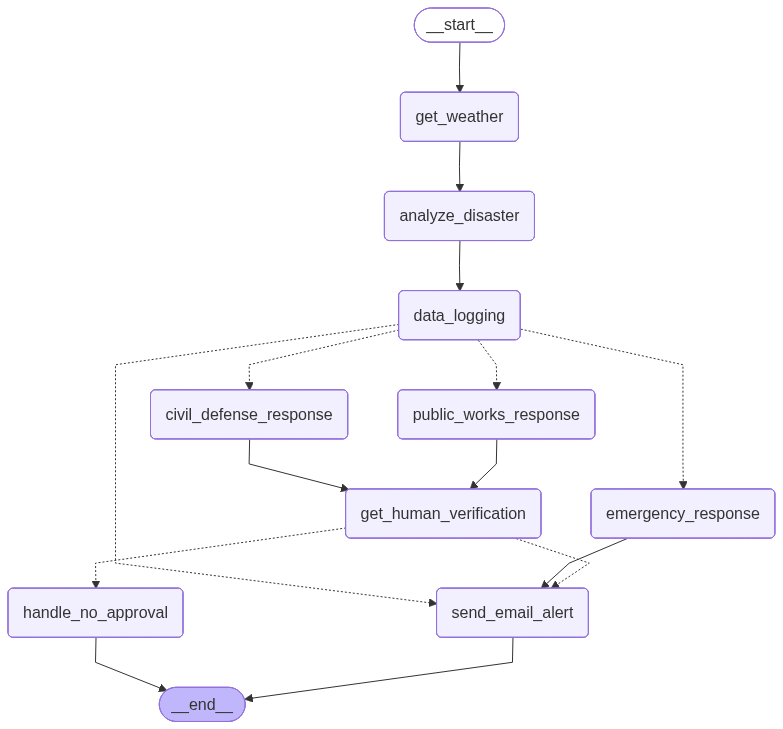

In [21]:
app

In [22]:
def run_weather_emergency_system(city: str):
    """Initialize and run the weather emergency system for a given city"""
    initial_state = {
        "city": city,
        "weather_data": {},
        "disaster_type": "",
        "severity": "",
        "response": "",
        "messages": [],
        "alerts": [],
        "social_media_reports": [],
        "human_approved": False
    }

    try:
        result = app.invoke(initial_state)
        print(f"Completed weather check for {city}")
        return result
    except Exception as e:
        print(f"Error running weather emergency system: {str(e)}")

In [26]:
run_weather_emergency_system("Hassan")


Low/Medium severity alert for Hassan requires human approval:
Disaster Type: No Immediate Threat
Current Weather: Patchy rain nearby
Temperature: 25.5°C
Wind Speed: 22.0 kph
Severity: low
Response Plan: **Civil Defense Response Plan for No Immediate Threat Situation with Low Severity Level in Hassan**

**I. Introduction**

This civil defense response plan is designed to address a No Immediate Threat situation with a low severity level in Hassan. The plan focuses on public safety measures to ensure the well-being of the community.

**II. Situation Assessment**

* The situation is assessed as a No Immediate Threat, indicating that there is no imminent danger to the public.
* The severity level is low, suggesting that the impact of the situation is minimal.

**III. Objectives**

* To ensure public safety and minimize disruptions to daily life.
* To provide a coordinated response to the situation.
* To maintain public awareness and education.

**IV. Public Safety Measures**

1. **Monitori

{'city': 'Hassan',
 'weather_data': {'weather': 'Patchy rain nearby',
  'wind_kph': 22.0,
  'wind_degree': 89,
  'temp_c': 25.5,
  'cloud': 89,
  'pressure_mb': 1007.0,
  'humidity': 69,
  'heatindex_c': 27.2,
  'precipitate_mm': 0.09},
 'disaster_type': 'No Immediate Threat',
 'severity': 'low',
 'response': '**Civil Defense Response Plan for No Immediate Threat Situation with Low Severity Level in Hassan**\n\n**I. Introduction**\n\nThis civil defense response plan is designed to address a No Immediate Threat situation with a low severity level in Hassan. The plan focuses on public safety measures to ensure the well-being of the community.\n\n**II. Situation Assessment**\n\n* The situation is assessed as a No Immediate Threat, indicating that there is no imminent danger to the public.\n* The severity level is low, suggesting that the impact of the situation is minimal.\n\n**III. Objectives**\n\n* To ensure public safety and minimize disruptions to daily life.\n* To provide a coordinat